* TODO: RUN BLACK
* TODO: FINISH WRITING
* TODO: Use a surface besides a circle?

# Near-field evaluation via quadrature by expansion (QBX). 

## 1. A brief intro to QBX.

### 1.1 Near-field evaluation
When working with boundary integral methods, it's common to need to evaluate surface integrals like:

$$u(x) = \int_{S} K(x, y) \phi(y) dy$$

where $K(x, y)$ is often a singular function with a form like $\log(\|x-y\|)$ or $\frac{1}{\|x-y\|}$. 

If $x$ is far away from $S$, then the integral is super easy to compute with standard quadrature rules like Gaussian quadrature or the trapezoidal rule. But, if $x$ is close to some part of $S$, then the singularity in $K(x,y)$ makes computation of the integral hard. This is called the **near-field evaluation problem**.

The brute force solution to the problem is to just increase the order of the quadrature rule you're using. Strictly speaking, this works. But, the number of quadrature points will grow prohibitively large as $x$ approaches $S$. Depending on the exact behavior of $K(x,y)$, the number of quadrature points might grow like $O(r^{-1})$ or $O(r^{-2})$ in terms of $r$, the shortest distance between $x$ and $S$. 

### 1.2 QBX

A robust and general solution to nearfield evaluation is a method called quadrature by expansion (**QBX**). The basic idea is to form a proxy for $u(x)$ "centered" at a point $c$ away from $S$ and then use that proxy to extrapolate to points that are close to $S$. There are several versions of QBX depending on the type of proxy used:
* The [original QBX paper](https://arxiv.org/abs/1207.4461) uses a separation of variables technique for the Helmholtz equation to form a series expansion in terms of Hankel functions and Bessel functions. This works for other PDEs if some separation of variables techniques are known. With Poisson and elasticity, we'd probably use polar expansions in 2D and a spherical harmonic expansion in 3D.
* The [quadrature by kernel-independent expansion (QBKIX) paper](https://arxiv.org/abs/1612.00977) forms a proxy set of point sources which replace the original integral locally arounding the expansion point $c$. This approach is "kernel-independent" since it will work well for most functions $K(x,y)$ even if the functions is complex enough that analytical techniques like separation of variables are too difficult.
* GigaQBX?

Ultimately, QBX approaches work because $u(x)$ is normally a smooth function, and approximating it directly provides a sort of backdoor around the singularities in $K(x,y)$. And, QBX methods are generally efficient because $c$ is far enough away from $S$ that the computation of the expansion is fairly cheap.

### 1.3 QBX via complex power series
Here, I'll focus specifically on a version of [QBX introduced here in section 5.3](https://arxiv.org/abs/1610.00823) that expands the solution in terms of a complex power series and works well for the Poisson equation and for elasticity in two dimensions. We re-write the observation coordinate into the complex plane. The observation point $\hat{x} = x_1 + ix_2$ and the expansion center $\hat{c} = c_1 + ic_2$ which is a distance $r$ from $S$.

$$u(x) = Re\big(\sum_{l=0}^{p} \alpha_l(\hat{x} - \hat{c})^l\big)$$

Then, the expansion coefficients ($\alpha$) are computed by computing a clever integral of $u(x)$ around a circle with radius $\delta r$ centered at $c$. Since, the whole point of this method is to solve the problem that computing $u(x)$ near the surface is hard, we need to make sure that the circle centered at $c$ has a radius substantially less than $r$. So, generally $\delta$ is chosen as 0.5. That will keep the evaluation points still far enough from the surface. For $l > 0$, the integral we compute is:

$$\alpha_l = \frac{1}{\pi (\delta r)^l}\int_{0}^{2\pi} u(c + \delta r(cos \theta, sin \theta)) e^{-il\theta} d\theta $$

and for $l=0$, we simply divide the above integral by two.

Because these expansion coefficient integrals are of a smooth function and are periodic, it makes sense to use a trapezoidal quadrature rule for integrating them. 

### 1.4 Summary

So, what's the full algorithm look like?

1. Choose an expansion center a distance of $r$ away from the surface.
2. Discretize the integrals for the expansion coefficients and identify the points where we will need to evaluate $u(c + \delta r(cos \theta, sin \theta))$.
3. Evaluate $u(x)$ for those points by directly evaluating $\int K(x, y) \phi(y) dy$ using a simple quadrature rule (e.g. Gaussian quadrature). Because we choose, $\delta = 1/2$, the closest we will have to evaluate $u(x)$ is $r/2$.
4. Integrate/sum to compute $\alpha_l$. 
5. Now that we have the coefficients $\alpha_l$, to evaluate $u(x)$ at any point arbitrarily close to the surface, simply evaluate the complex power series and take the real part. 

Some comments about QBX:
* Because the evaluation of the series is independent of the computation of the coefficients, we can compute many near-field values for the price of one.
* The method actually works just as well for computing a $u(x)$ directly on the boundary. To be precise, we can compute a limit to the boundary like $\lim_{x \to S^+}u(x)$. Thus, QBX can actually replace the singular quadrature required in many boundary integral methods.
* The method works best when there are no singularities in $u(x)$. The most common violation of this is a sharp corner in $S$. When there are corners, QBX will still work, but the expansion center $c$ will need to be closer to the surface and a high number of quadrature points might be needed in the vicinity of the corner. 
* There are three relevant parameters which all control the accuracy. The distance to offset from the surface, $R$. The order of the expansion, $p$. And the order of quadrature method used to compute the coefficients of the expansion, $n_q$. They interact in somewhat complex ways. 
* By increasing $R$, the expansion is formed further from the surface and (holding $n_q$ constant) the expansion coefficients will be computed more accurately, but (holding $p$ constant) the accuracy of the expansion near the surface will decrease because the distance from the evaluation point to the expansion center is larger. 
* Increasing $p$ will improve the accuracy of the expansion up to a point, but eventually the higher order terms in the expansion will become corrupted by the error introduced by the numerical integration. So, in order to increase $p$, $n_q$ must also increase.

## 2. Implementation

### 2.1 The double layer potential on a circle.

Great, let's put together a simple implementation for the Laplace double layer potential! So, we're computing the electric or magnetic potential due to a dipolar surface. Or, the displacement due to a earthquake under assumptions of antiplane strain. How easily does this extend to 2D plane-strain elasticity? Super easily. In fact, basically nothing needs to change except that we do everything four times, once for each component of the 2x2 tensor form of the equations! 

First, we'll set up a few useful functions: a couple quadrature rules and a definition of the circular geometry we'll be using.

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# the n-point gauss quadrature rule on [-1, 1], returns tuple of (points, weights)
def gauss_rule(n):
    k = np.arange(1.0, n)
    a_band = np.zeros((2, n))
    a_band[1, 0:(n - 1)] = k / np.sqrt(4 * k * k - 1)
    x, V = scipy.linalg.eig_banded(a_band, lower=True)
    w = 2 * np.real(np.power(V[0, :], 2))
    return x, w

# the n-point trapezoidal rule on [-1, 1], returns tuple of (points, weights)
def trapezoidal_rule(n):
    return np.linspace(-1.0, 1.0, n + 1)[:-1], np.full(n, 2.0 / n)

# our simple curve functions will return (x, y, nx, ny, jacobian)
# because the input quadrature rule is on the domain [-1, 1], the 
# jacobian of the transformation for a circle with radius 1 is 
# constant and equal to pi.
def circle(quad_pts):
    theta = np.pi * (quad_pts + 1)
    x = np.cos(theta)
    y = np.sin(theta)
    return x, y, x, y, np.pi

If we discretize the integral for many observation points

$$u(x) = \int_{S} K(x, y) \phi(y) dy$$

the result:

$$u_i = \sum_j K(x_i, y_j) \phi(y_j)$$

can be written in matrix form:

$$\textbf{u} = \textbf{A} \textbf{b}$$

where the matrix of interest is $A_{ij} = K(x_i, y_j)$. This function computes that matrix! 

In [2]:
def double_layer_matrix(surface, quad_rule, obsx, obsy):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface
    
    dx = obsx[:, None] - srcx[None, :]
    dy = obsy[:, None] - srcy[None, :]
    r2 = dx ** 2 + dy ** 2

    # The double layer potential
    integrand = -1.0 / (2 * np.pi) * (dx * srcnx[None, :] + dy * srcny[None, :]) / r2
    
    return integrand * curve_jacobian * quad_rule[1][None, :]

So, let's plot up what $u(x)$ looks like. For the rest of this notebook, we'll use the simple $\phi(y) = y_2$ as the source function. Let's start by using a fairly low quadrature order, just 50 points on the whole circle.

In [3]:
nobs = 100
xs = np.linspace(-2, 2, nobs)
ys = np.linspace(-2, 2, nobs)
obsx, obsy = np.meshgrid(xs, ys)

quad_rule_low = trapezoidal_rule(50)
surface_low = circle(quad_rule_low[0])

And this is the meat of the $\textbf{u} = \textbf{A}\textbf{b}$ calculation:

In [4]:
A = double_layer_matrix(
    surface   = surface_low,
    quad_rule = quad_rule_low,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten()
)
phi = surface_low[1] # phi = y_2
u = A.dot(phi) # u = Ab
u = u.reshape(obsx.shape)

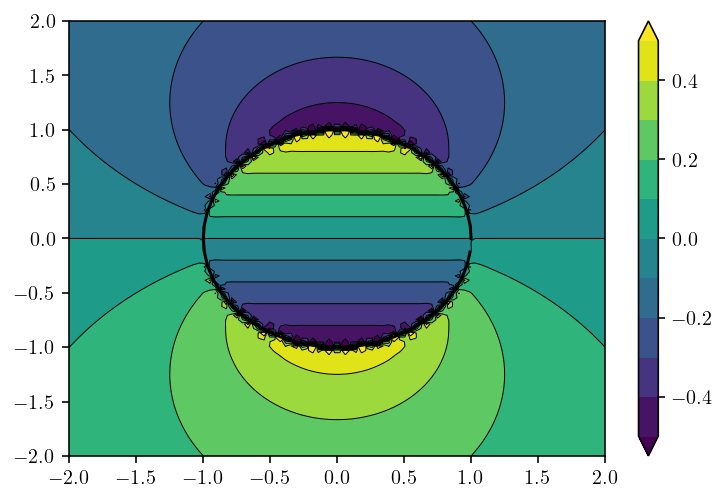

In [5]:
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, u, levels = np.linspace(-0.5,0.5,11), extend="both")
plt.contour(xs, ys, u, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.5,0.5,11), extend="both")
plt.colorbar(cntf)
plt.show()

Pretty picture! But, you can immediately see the uglyness near the boundary. This is what we'll solve with QBX! Let's actually quantify that error. We'll compare our 50 point integration against a 2000 point integration.

In [6]:
zoomnobs = 200
zoomx = [-1.6, -0.4]
zoomy = [-0.6, 0.6]
zoomxs = np.linspace(*zoomx, zoomnobs)
zoomys = np.linspace(*zoomy, zoomnobs)
zoomobsx, zoomobsy = np.meshgrid(zoomxs, zoomys)
zoomu_low = double_layer_matrix(surface_low, quad_rule_low, zoomobsx.flatten(), zoomobsy.flatten())\
    .dot(surface_low[1]).reshape(zoomobsx.shape)

quad_rule_high = trapezoidal_rule(2000)
surface_high = circle(quad_rule_high[0])
zoomu_high = double_layer_matrix(surface_high, quad_rule_high, zoomobsx.flatten(), zoomobsy.flatten())\
    .dot(surface_high[1]).reshape(zoomobsx.shape)

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


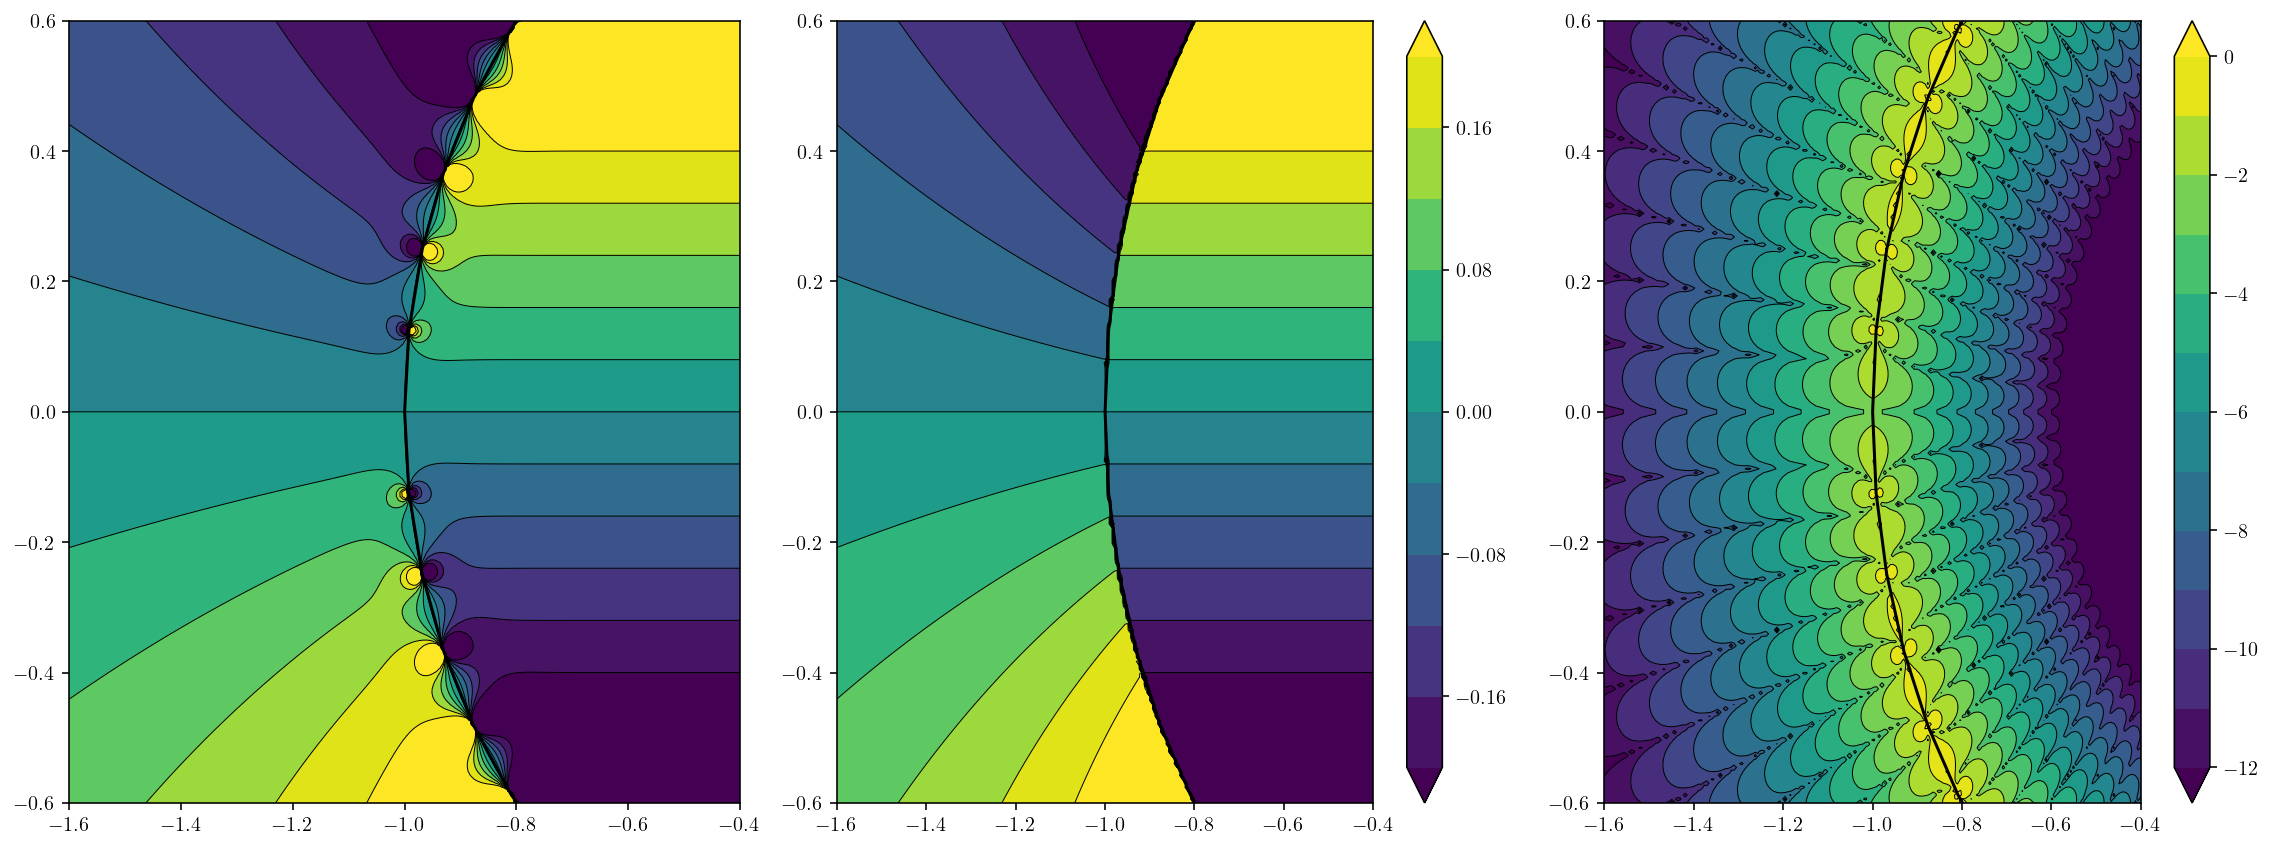

In [7]:
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(zoomxs, zoomys, zoomu_low, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_low, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
cntf = plt.contourf(zoomxs, zoomys, zoomu_high, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_high, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_low - zoomu_high))
logerror[np.isinf(logerror)]=-12.0
cntf = plt.contourf(zoomxs, zoomys, logerror, levels = np.linspace(-12, 0, 13), extend="both")
plt.contour(zoomxs, zoomys, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 0, 13), extend="both")
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

We're zoomed in on the left edge of the circle here which shows the little dipoles from the low order quadrature on the left. In the middle, the super high order quadrature cleans up the picture (but, note that if you zoomed in by a factor of 10x, you'd see the dipoles again even with the 2000 point quadrature). The right hand figure shows the $\log_{10}$ error in the low order integrals. The error very close to the surface is more-or-less 100%.

Let's try again with the low-order quadrature rule but this time using QBX! We're going to use a tenth order expansion centered at $(-1.5, 0.2)$.

In [8]:
qbx_p = 10
qbx_center_x = -1.5
qbx_center_y = 0.2

So, we now need to compute the circular integrals for the coefficients. A rule of thumb is to use a trapezoid rule with $2p$ points.

In [9]:
trap_x, trap_weights = trapezoidal_rule(2 * qbx_p)

# transform the quadrature rule from [-1, 1] to [0, 2*pi]
trap_theta = np.pi * (trap_x + 1)
trap_weights *= np.pi # multiply by the jacobian of the transformation

Our expansion center is approximately a distance of 0.5 from the boundary, so we our coefficient integrals are computed a distance of 0.25 from the expansion center (remember $\delta = 1/2$).

In [10]:
qbx_delta_r = 0.25
# (qbx_x, qbx_y) defines the points used for computing the circular coefficient integrals centered at the expansion center.
qbx_x = (qbx_delta_r * np.cos(trap_theta) + qbx_center_x)
qbx_y = (qbx_delta_r * np.sin(trap_theta) + qbx_center_y)

Now, we need the value of $u(x)$ at the points `(qbx_x, qbx_y)`.

In [11]:
qbx_u = double_layer_matrix(surface_low, quad_rule_low, qbx_x, qbx_y).dot(phi)

And here we implement the coefficient integrals. This looks ugly, but it's a direct implementation of the discretized coefficient integrals where $\omega_i$ are the quadrature weights `trap_ws`

$$\alpha_l = \frac{1}{\pi (\delta r)^l}\sum_{i=0}^{2p} \omega_i u(c + \delta r(cos \theta_i, sin \theta_i)) e^{-il\theta_i} $$


In [13]:
alpha = []
for L in range(qbx_p):
    C = 1.0 / (np.pi * (qbx_delta_r ** L))
    if L == 0:
        C /= 2.0
    alpha.append(C * np.sum(trap_weights * qbx_u * np.exp(-1j * L * trap_theta)))

We convert the expansion center and the observation points to be complex. 

In [14]:
zoom_complex = zoomobsx + zoomobsy * 1j
qbx_center = qbx_center_x + qbx_center_y * 1j

And finally, evaluate the expansion in complex space:

In [15]:
zoomu_qbx = np.zeros_like(zoomu_low)
for L in range(qbx_p):
    zoomu_qbx += np.real(alpha[L] * ((zoom_complex - qbx_center) ** L))

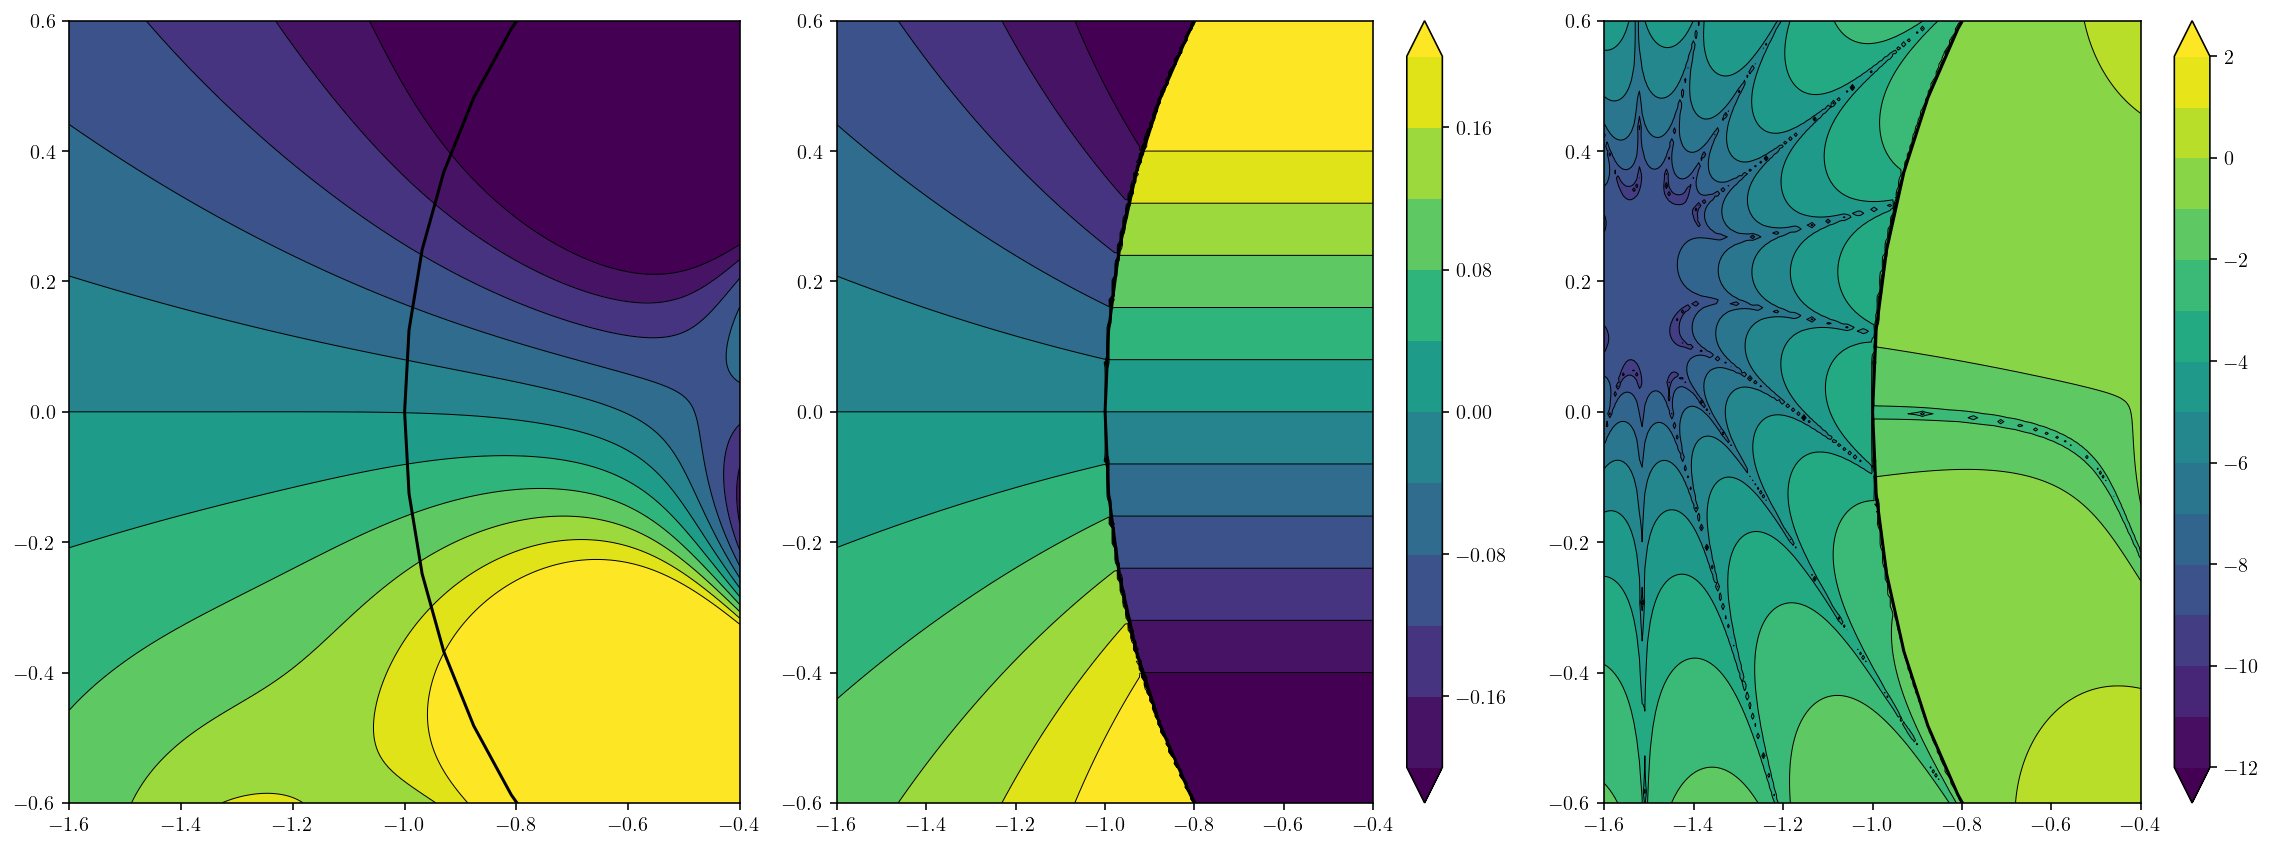

In [16]:
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(zoomxs, zoomys, zoomu_qbx, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_qbx, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
cntf = plt.contourf(zoomxs, zoomys, zoomu_high, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.contour(zoomxs, zoomys, zoomu_high, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-0.2,0.2,11), extend="both")
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_qbx - zoomu_high))
logerror[np.isinf(logerror)]=-12.0
cntf = plt.contourf(zoomxs, zoomys, logerror, levels = np.linspace(-12, 2, 15), extend="both")
plt.contour(zoomxs, zoomys, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 2, 15), extend="both")
plt.colorbar(cntf)
plt.plot(surface_low[0], surface_low[1], 'k-', linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

The left panel here shows $u(x)$ from the QBX evaluation, the middle panel shows $u(x)$ from the 2000 point quadrature and the right panel shows the $\log_{10}$ error in the QBX evaluation. Take-aways:
* The error near the portion of the surface closest to the expansion center is now quite good. We're succesfully doing an accurate near-field evaluation!
* Points far away from the expansion center are less accurate.
* The QBX expansion is entirely wrong interior to the circle on the other side of the surface. This is entirely expected since there is a jump in $u(x)$ across the surface and a step function like that would be impossible to approximate with a power series.

### 2.2 Building a practical tool

While what we did so far is a cool demonstration, it's not a practical implementation. Ultimately, we need to be able to provide a big list of observation points and expect the code to choose whether to compute the integral directly or, if a point is near the surface, use QBX. And, we need to assign points to which expansion they are going to use.

First, I'll skim over the implementation of a couple functions that generalize and vectorize the code from above. 

In [17]:
def qbx_expand_matrix(surface, quad_rule, qbx_p = 5, mult = 5.0, direction = 1.0):
    # Instead of computing for a single expansion center, we'll do it for many at once. 
    # There will be one expansion center for each point on the input surface. 
    # We'll also compute the matrix form so that we can apply it multiply times for different source functions.
    srcx, srcy, srcnx, srcny, curve_jacobian = surface

    qbx_nq = 2 * qbx_p + 1
    qbx_qx, qbx_qw = trapezoidal_rule(qbx_nq)
    qbx_qw *= np.pi
    qbx_theta = np.pi * (qbx_qx + 1)

    
    # The expansion center will be offset from the surface in the direction of (srcnx, srcny)
    quad_pt_spacing = curve_jacobian * quad_rule[1]
    qbx_r = mult * quad_pt_spacing
    qbx_eval_r = qbx_r * 0.5
    center_x = srcx + direction * qbx_r * srcnx
    center_y = srcy + direction * qbx_r * srcny

    # The coefficient integral points will have shape (number of expansions, number of quadrature points). 
    qbx_x = center_x[:, None] + qbx_eval_r[:, None] * np.cos(qbx_theta)[None, :]
    qbx_y = center_y[:, None] + qbx_eval_r[:, None] * np.sin(qbx_theta)[None, :]
    
    qbx_u_matrix = double_layer_matrix(surface, quad_rule, qbx_x.flatten(), qbx_y.flatten()).reshape((*qbx_x.shape, srcx.shape[0]))

    # Compute the expansion coefficients in matrix form.
    alpha = np.empty((srcx.shape[0], qbx_p, srcx.shape[0]), dtype=np.complex)
    for L in range(qbx_p):
        C = 1.0 / (np.pi * (qbx_eval_r ** L))
        if L == 0:
            C /= 2.0
        oscillatory = qbx_qw[None,:,None] * np.exp(-1j * L * qbx_theta)[None,:,None]
        alpha[:, L, :] = C * np.sum(qbx_u_matrix * oscillatory, axis=1)
    return alpha, center_x, center_y, qbx_r

def qbx_eval_matrix(obsx, obsy, center_x, center_y, qbx_p = 5):
    # Construct a matrix that evaluates the QBX expansions. This should look very similar to the single-expansion case above.
    obs_complex = obsx + obsy * 1j
    qbx_center = center_x + center_y * 1j
    sep = obs_complex - qbx_center[None, :]
    out = np.empty((obsx.shape[0], obsx.shape[1], qbx_p), dtype=np.complex)
    for L in range(qbx_p):
        out[:, :, L] = sep ** L
    return out

Next up is the fun part. This function identifies which expansion center is closest the observation points and uses that expansion only when appropriate. See the inline comments!

In [26]:
from scipy.spatial import cKDTree
def qbx_interior_eval(surface, quad_rule, density, obsx, obsy, qbx_center_x, qbx_center_y, qbx_coeffs):
    # Build a KDTree for doing nearest neighbor searches amongst the QBX centers
    center_pts = np.array([qbx_center_x, qbx_center_y]).T
    qbx_centers_tree = cKDTree(center_pts)
    
    # And also for doing nearest neighbor searches on the source surface.
    surface_pts = np.array([surface[0], surface[1]]).T
    surface_tree = cKDTree(surface_pts)

    lookup_pts = np.array([obsx.flatten(), obsy.flatten()]).T
    
    # Identify the distance to the closest expansion, which expansion that is, and the distance to the surface. 
    dist_to_expansion, closest_expansion = qbx_centers_tree.query(lookup_pts)
    dist_to_surface, _ = surface_tree.query(lookup_pts)

    # Only use QBX if point is close enough to the surface and the point is close enough to its respective QBX expansion center
    # To measure "close enough", we use qbx_r, which is the distance from the surface.
    use_qbx = (dist_to_expansion < qbx_r[closest_expansion]) & (dist_to_surface < qbx_r[closest_expansion])
    
    # And we identify which expansion centers are ever used, and how many times.
    qbx_centers_used, center_counts = np.unique(closest_expansion[use_qbx], return_counts=True)
    
    # This part is slightly complex. The vectorization in qbx_eval_matrix means that for each QBX center, 
    # we need to compute the same number of observation points. So, we find the maximum number of 
    # observation points for any expansion center. qbx_eval_pts is going to be the list of points for each expansion center
    # orig_pt_idxs is a mapping back to which indices those points correspond to in the original obsx and obsy input arrays.
    # Because some expansion centers won't use the full n_max_per_qbx_center observation points, orig_pt_idxs equals -1 by 
    # default. This will be used later to identify which entries are valid and which are just "vectorization junk".
    n_max_per_qbx_center = np.max(center_counts)
    qbx_eval_pts = np.zeros((n_max_per_qbx_center, qbx_centers_used.shape[0], 2))
    orig_pt_idxs = np.full((n_max_per_qbx_center, qbx_centers_used.shape[0]), -1, dtype=np.int)
    for i, c, in enumerate(qbx_centers_used):
        # So, for each QBX center, we find the observation points that use it.
        I = np.where((closest_expansion == c) & use_qbx)[0]
        orig_pt_idxs[:I.shape[0], i] = I
        qbx_eval_pts[:I.shape[0], i] = lookup_pts[orig_pt_idxs[:I.shape[0], i], :]
        
    # Now, we get to actually computing integrals.
    # First, compute the brute force integral for every observation point. We'll just overwrite the ones using QBX next.
    out = double_layer_matrix(
        surface   = surface,
        obsx      = obsx.flatten(), 
        obsy      = obsy.flatten(),
        quad_rule = quad_rule
    ).dot(density)
    
    # This is the matrix that maps from QBX coeffs to observation point 
    Q = qbx_eval_matrix(qbx_eval_pts[:,:,0], qbx_eval_pts[:,:,1], qbx_center_x[qbx_centers_used], qbx_center_y[qbx_centers_used], qbx_p = qbx_p)
    
    # And perform a summation over the terms in each QBX. axis=2 is the summation over the l index in the alpha expansion coefficients.  
    out_for_qbx_points = np.sum(Q * qbx_coeffs[qbx_centers_used][None,:,:], axis=2)
    
    # Finally, use the QBX evaluation where appropriate. If orig_pt_idxs == -1, the entries are vectorization junk.
    out[orig_pt_idxs[orig_pt_idxs >= 0]] = out_for_qbx_points[orig_pt_idxs >= 0]
    
    return out.reshape(obsx.shape)

In [27]:
n = 200
quad_rule = trapezoidal_rule(n)
surface = circle(quad_rule[0])

In [28]:
nobs = 400

zoomx = [0.75, 1.25]
zoomy = [0.15, 0.65]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

In [29]:
bie_eval = double_layer_matrix(
    surface   = surface,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = quad_rule
).dot(surface[1]).reshape(obsx.shape)

quad_rule_high = trapezoidal_rule(2000)
surface_high = circle(quad_rule_high[0])
bie_eval_high = double_layer_matrix(
    surface   = surface_high,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = quad_rule_high
).dot(surface_high[1]).reshape(obsx.shape)

In [22]:
qbx_p = 8
Qexpand, qbx_center_x, qbx_center_y, qbx_r = qbx_expand_matrix(surface, quad_rule, qbx_p = qbx_p, mult = 5.0, direction = 1.0)
qbx_coeffs = Qexpand.dot(surface[1])

In [22]:
use_idx = int(0.07 * n)
r = np.sqrt((obsx - qbx_center_x[use_idx]) ** 2 + (obsy - qbx_center_y[use_idx]) ** 2)
rcenter = np.sqrt((obsx - 0) ** 2 + (obsy - 0) ** 2)
use_qbx = np.where((r <= qbx_r[use_idx]))

Qeval_obs = qbx_eval_matrix(obsx[use_qbx].reshape((-1,1)), obsy[use_qbx].reshape((-1,1)), qbx_center_x[use_idx:use_idx+1], qbx_center_y[use_idx:use_idx+1], qbx_p = qbx_p)

bie_eval_qbx = bie_eval.copy()
bie_eval_qbx[use_qbx] = 0
for L in range(qbx_p):
    bie_eval_qbx[use_qbx] += np.real(Qeval_obs[:,0,L] * qbx_coeffs[use_idx, L])

In [23]:
bie_eval_full_qbx = qbx_interior_eval(surface, quad_rule, surface[1], obsx, obsy, qbx_center_x, qbx_center_y, qbx_coeffs)

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


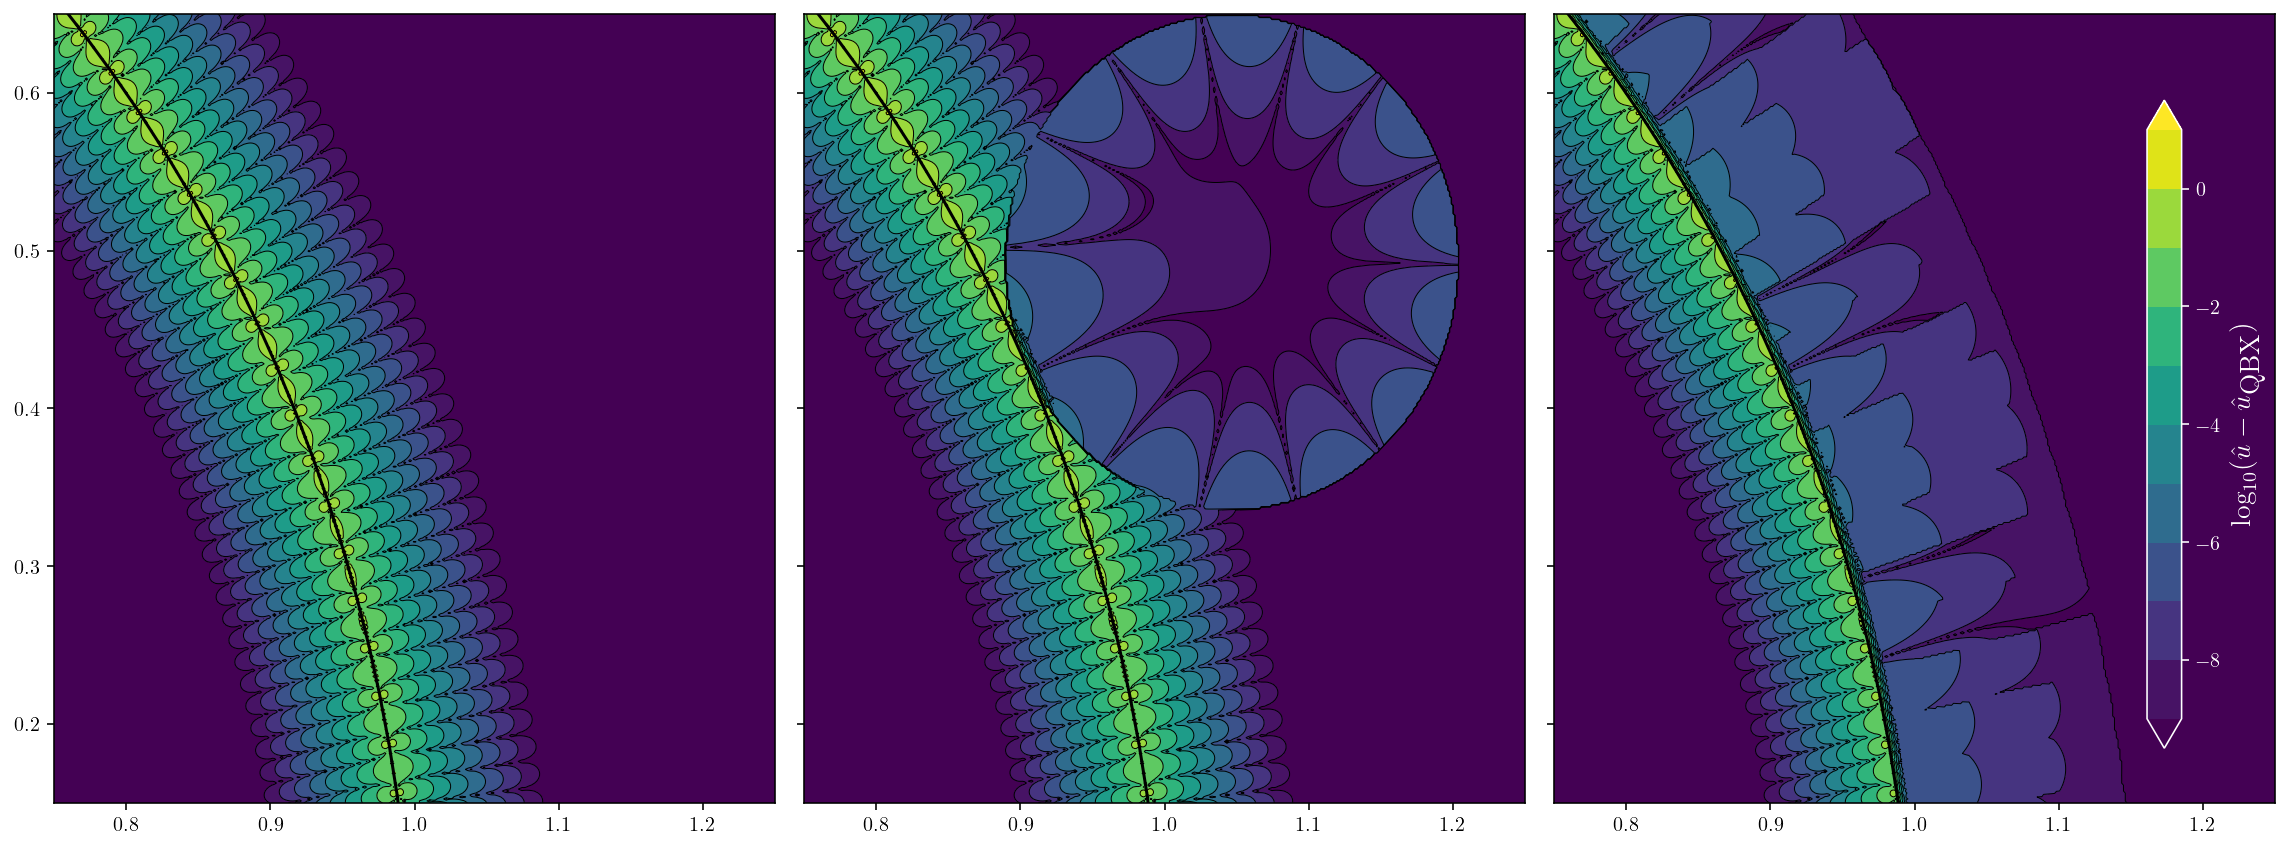

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (16,6))
plt.subplot(1,3,1)
logerror = np.log10(np.abs(bie_eval_high - bie_eval))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
error_levels = np.linspace(-9, 1, 11)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,3,2)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_qbx))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(1,3,3)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_full_qbx))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])

#fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.935, 0.125, 0.015, 0.75])
cb = fig.colorbar(cntf, cax=cbar_ax)

cb.set_label('$\log_{10}(\hat{u} - \hat{u}_{\\textrm{QBX}})$', color='w', fontsize=14)
cb.ax.yaxis.set_tick_params(color='w')
cb.outline.set_edgecolor('w')
cbytick_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cbytick_obj, color='w')

plt.tight_layout()
plt.savefig('qbx.pdf')
plt.show()

The left figure shows the $\log_{10}$ error for a naive brute-force integration. The middle figure shows the $\log_{10}$ error when we use a single QBX expansion center. The right figure shows the $\log_{10}$ when we use the closest QBX expansion center for every exterior point close to the boundary. The error is reduced from ~100% to ~0.0001% right near the boundary!

In the next part, I'll show how QBX can go beyond near-field evaluation and be used for actually solving boundary integral equations.